In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [75]:
import json
import os
from glob import glob
import k3d
import trimesh
from imageio import imread, imwrite

In [3]:
def to_arr(m):
    m = np.array(m)
    shape = int(np.sqrt(m.shape[0]))
    return m.reshape((shape,shape))

def project_point_mvp(p_in, mvp, image_width, image_height):
    p0 = np.append(p_in, [1])
    e0 = np.dot(mvp, p0)
    e0[:3] /= e0[3]
    pos_x = e0[0]
    pos_y = e0[1]
    px = (0.5 + (pos_x) * 0.5) * image_width
    py = (1.0 - (0.5 + (pos_y) * 0.5)) * image_height
    return px, py

## Path to your scan ##

In [ ]:
scan_path = "./chair_scan/"

## Load JSON Frames 

In [13]:
frame_paths = list(sorted( glob(os.path.join(scan_path, "*.json"))  ))
frame_paths = list(filter( lambda x : "frame_" in x, frame_paths))

In [18]:
class Frame():
    pose = None 
    projection_matrix = None
    intrinsics = None 
    image_path = None
    def from_json(json_path):
        d = json.load( open(json_path,'r') )
        f = Frame()
        f.image_path = json_path.replace(".json", ".jpg")
        f.has_image = os.path.exists(f.image_path)
        f.pose = to_arr(d["cameraPoseARFrame"])
        f.projection_matrix = to_arr(d["projectionMatrix"])
        f.intrinsics = to_arr(d["intrinsics"])
        return f
    

In [19]:
frames = list( map( Frame.from_json, frame_paths ) )

In [20]:
# Filter frames with images 
frames = list(filter( lambda f : f.has_image, frames ))

In [50]:
len(frames)

24

In [22]:
image = imread( frames[0].image_path )

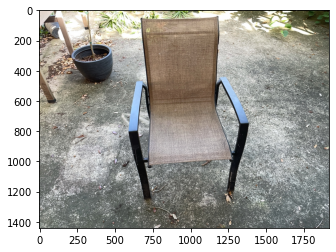

In [23]:
imshow(image)

In [26]:
image_height, image_width = image.shape[:2]

## Show 3d trajectory + camera poses 

In [28]:
def k3d_frustrum(pose, size=0.009, color=0x0000ff):
    # i.e. not using image sizes 
    pos = pose[:3, 3]
    
    forward = pose[:3, 2] * size * -1.4
    right = pose[:3, 0] * size * 1.25
    up = pose[:3, 1] * size
    
    #verts = [pos, pos + forward*size ]
    verts = [pos, pos + forward - right*0.5 + up*0.5, pos + forward + right * 0.5 + up * 0.5, pos ]
    verts += [pos, pos + forward - right*0.5 - up*0.5, pos + forward + right * 0.5 - up * 0.5, pos ]
    verts += [pos, pos + forward - right*0.5 + up*0.5, pos + forward - right * 0.5 - up * 0.5, pos]
    verts += [pos, pos + forward + right*0.5 + up*0.5, pos + forward + right * 0.5 - up * 0.5, pos]
    return k3d.line(verts, color=color, width=2.5, shader="simple")


In [30]:
vertices = [ ]

frustrums = []

colors = [0xff0000, 0x00ff00, 0x0000ff, 0xffcc00, 0xccff00, 0x00ccff]

for i, frame in enumerate(frames):
    pos = frame.pose[:3, 3] 
    vertices += pos.tolist()
    frustrums.append( k3d_frustrum(frame.pose, size=0.1, color=colors[i % len(colors)]) )

vertices = np.array(vertices)

In [31]:
#line = k3d.line((0, 0, 0, 5, 10, 15), shader="simple")
lines = k3d.line(vertices, color=0xff0000, width=2.5, shader="simple") # + line
pts = k3d.points(vertices, point_size=0.003)

plot3d = k3d.plot(antialias=True, camera_auto_fit=True)

plot3d += lines
plot3d += pts 

for f in frustrums:
    plot3d += f

plot3d += k3d.points( [vertices[:3]], point_size=0.0075, color=0x00ff00)


/Users/cc/opt/anaconda3/envs/o3d12/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


In [32]:
obj_file = os.path.join(scan_path, "textured_output.obj")
obj_scene = trimesh.load(obj_file)
meshes = [obj_scene]

In [33]:
def concat_meshes(meshes):
    # append faces and vertices of meshes
    vertices, faces = trimesh.util.append_faces(
        [m.vertices.copy() for m in meshes],
        [m.faces.copy() for m in meshes])
    return trimesh.Trimesh(vertices=vertices, faces=faces)
    

In [34]:
mesh = concat_meshes(meshes)

In [35]:
plot3d += k3d.mesh(mesh.vertices, mesh.faces.flatten(), color=0xffcc00)

/Users/cc/opt/anaconda3/envs/o3d12/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


In [47]:
plot3d.display()

Output()

In [49]:
# Look at front of chair 
cam = [-0.6614672297218448,
 1.7325690595875158,
 1.9989032254199415,
 0.1724782831668854,
 0.7360384085848928,
 0.49226170253753665,
 0.23427211001516093,
 0.8918014915135656,
 -0.3870486767878707]
plot3d.camera = cam

## Project mesh points onto image

In [71]:
frame_idx = 5 
frame = frames[frame_idx]

pose = frame.pose.copy()

K = frame.intrinsics

projection = frame.projection_matrix

view_matrix = np.linalg.inv(pose)

In [72]:
w = image_width
h = image_height

In [73]:
points = []

for p3d in mesh.vertices[::2]:
    
    mvp = np.dot(projection, view_matrix)
    pt2d = project_point_mvp(p3d, mvp, w, h)
    
    x,y = pt2d[:2]
    
    if x >= 0 and x < w and y >= 0 and y < h:
        points.append( (x,y) )
    
points = np.array(points)



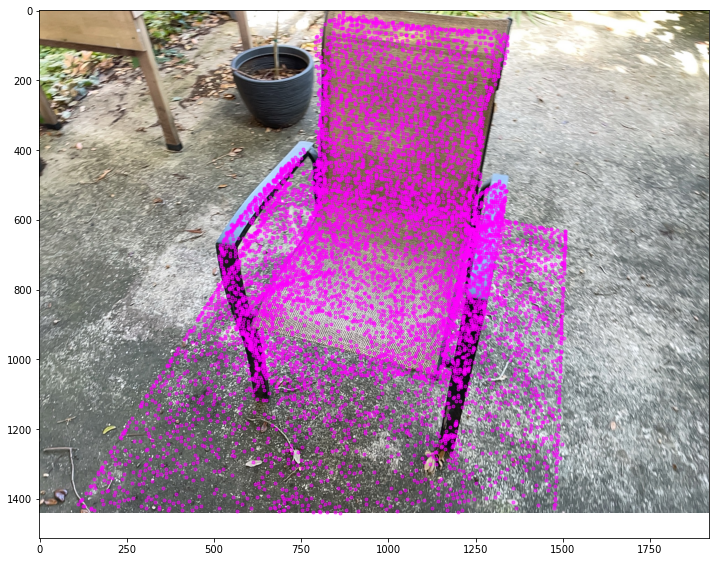

In [74]:
figure(figsize=(12,12))

imshow( imread(frame.image_path) )

plot( points[:,0], points[:,1] , '.', color='magenta', alpha=0.5)
